## **Assignment Three (EECS3404 W25)**

**your name (your student number):** arianne ghislaine rull (219129527) \\
**your yorku email: arianneghislaine@gmail.com**

This assignment is mainly for you to review neural networks and deep learning models. You have to work individually. Remember to fill in your information (name, student number, email) at above.


##**What to Submit**

Use **one** notebook file (*.ipynb*) for **each** question, which should contain all of your answers and codes. You must zip all three notebooks into one zip file to submit it onto eClass.
No late submission will be accepted.

* For all written parts, write your answers in text cells. To avoid confusions in marking, better to embed latex codes there to represent all mathematical notations and equations.  No handwriting is accepted.

* For programming parts, you should give codes, comments, explanations and the proper running outputs in both code and text cells. Make your jupyter notebook clean and concise. Remove all unused codes and all intermediate results from the submitted notebook. The submitted notebook should include only the final (best) outputs for each question. Also make sure every code cell runnable so that markers can reproduce the outputs if necessary.

### **Q1** (20 marks) **Deep Neural Networks for nonlinear feature extraction**


Based on [the implementation of fully-connected deep neural networks at Colab](https://colab.research.google.com/drive/17tsPsWo3aEC9Aldi0umNkrVH0BXtUhnj), use `JAX` autograd to implement a nonlinear feature extraction method using deep neural networks:

*   Bottleneck features (Section 4.4.2)

for the MNIST data.

Use all training data of 10 digits to train these the Bottleneck feature extractor and  investigate various network structures (such as different number of layers and nodes per layer) for the best possible classification performance. When you measure the classification performance, please use the best
 `scikit-learn` nonlinear SVM (Gaussian kernel) code as you did in **Assignment 2** to implement a binary classifier on the extracted features of the training data of two digits ('1' vs. '7').

 At last,  report the best configuration and its corresponding classification accuracy in the heldout test images for two digits ('1' vs. '7').
Discuss your findings in experiments.


In [ ]:
import jax
import jax.numpy as jnp
from jax import random, grad, jit
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import numpy as np
from tensorflow.keras.datasets import mnist


In [ ]:

# 1) Load MNIST from Keras
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# X_train: (60000, 28, 28), y_train: (60000,)
# X_test:  (10000, 28, 28), y_test:  (10000,)

# 2) Reshape to [N, 784] and convert to float32
X_train_full = X_train.reshape(-1, 784).astype(np.float32)
X_test_full  = X_test.reshape(-1, 784).astype(np.float32)

# 3) Scale pixel values to [0,1]
X_train_full /= 255.0
X_test_full  /= 255.0

# 4) Labels remain in y_train, y_test
y_train_full = y_train.astype(int)
y_test_full  = y_test.astype(int)

print("X_train_full shape:", X_train_full.shape)  # (60000, 784)
print("y_train_full shape:", y_train_full.shape)  # (60000,)
print("X_test_full shape: ", X_test_full.shape)   # (10000, 784)
print("y_test_full shape: ", y_test_full.shape)   # (10000,)


X_train_full shape: (60000, 784)
y_train_full shape: (60000,)
X_test_full shape:  (10000, 784)
y_test_full shape:  (10000,)


In [ ]:
# 2) Define MLP with a "bottleneck" layer
#    Example architecture: 784 -> 256 -> 32 -> 256 -> 10
#    The '32' layer is our bottleneck.


LAYER_SIZES = [784, 256, 32, 256, 10]
key = random.PRNGKey(42)
BATCH_SIZE = 128
EPOCHS = 5
LEARNING_RATE = 1e-3

In [ ]:
# Weight initialization (Glorot / Xavier)
def glorot_init(rng, fan_in, fan_out):
    limit = jnp.sqrt(6.0 / (fan_in + fan_out))
    return random.uniform(rng, (fan_in, fan_out), minval=-limit, maxval=limit)

def init_params(layer_sizes, rng):
    params = []
    for i in range(len(layer_sizes) - 1):
        in_dim, out_dim = layer_sizes[i], layer_sizes[i+1]
        rng, layer_rng = random.split(rng)
        W = glorot_init(layer_rng, in_dim, out_dim)
        b = jnp.zeros((out_dim,))
        params.append((W, b))
    return params

params = init_params(LAYER_SIZES, key)

In [ ]:
# Forward pass that also returns the bottleneck activation
# x: shape [batch_size, 784]
# Returns (bottleneck_activations, logits)

def forward_with_bottleneck(params, x):

    activ = x
    bottleneck_activ = None
    for layer_idx, (W, b) in enumerate(params):
        z = jnp.dot(activ, W) + b

        # If it's not the last layer, apply ReLU
        if layer_idx < len(params) - 1:
            activ = jax.nn.relu(z)
            # If this layer is the bottleneck (index=2 in our example):
            if layer_idx == 1:
                bottleneck_activ = activ
        else:
            # final layer -> raw logits
            activ = z

    # bottleneck_activ is the activation after the second layer
    # (i.e., the 32-dimensional layer in [784, 256, 32, 256, 10])
    return bottleneck_activ, activ

In [ ]:
def cross_entropy_loss(params, x, y):
    # Forward pass
    _, logits = forward_with_bottleneck(params, x)
    log_probs = jax.nn.log_softmax(logits, axis=1)
    one_hot = jax.nn.one_hot(y, 10)
    return -jnp.mean(jnp.sum(one_hot * log_probs, axis=1))

def accuracy(params, x, y):
    # We only need logits
    _, logits = forward_with_bottleneck(params, x)
    preds = jnp.argmax(logits, axis=1)
    return jnp.mean(preds == y)

In [ ]:
# -- Single SGD update step --
@jit
def update(params, x, y, lr):
    loss_fn = lambda p: cross_entropy_loss(p, x, y)
    grads = grad(loss_fn)(params)
    new_params = []
    for (W, b), (dW, db) in zip(params, grads):
        new_params.append((W - lr * dW, b - lr * db))
    return new_params


In [ ]:
# 3) Mini-batch training on digits 0..9

def get_minibatches(X, y, batch_size):
    # Simple utility to yield mini-batches
    # Shuffles once per epoch
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    for start_idx in range(0, len(X), batch_size):
        batch_idx = indices[start_idx : start_idx + batch_size]
        yield X[batch_idx], y[batch_idx]

for epoch in range(EPOCHS):
    # Training loop
    avg_loss = 0.0
    num_batches = len(X_train_full) // BATCH_SIZE
    for X_batch_np, y_batch_np in get_minibatches(X_train_full, y_train_full, BATCH_SIZE):
        X_batch = jnp.array(X_batch_np)
        y_batch = jnp.array(y_batch_np)
        params = update(params, X_batch, y_batch, LEARNING_RATE)
        batch_loss = cross_entropy_loss(params, X_batch, y_batch)
        avg_loss += batch_loss

    avg_loss /= num_batches

    # Evaluate on test set (all digits)
    test_acc = accuracy(params, jnp.array(X_test_full), jnp.array(y_test_full))
    print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {avg_loss:.4f} | Test Acc (0-9): {test_acc:.4f}")

Epoch 1/5 | Loss: 2.2874 | Test Acc (0-9): 0.1766
Epoch 2/5 | Loss: 2.2376 | Test Acc (0-9): 0.3051
Epoch 3/5 | Loss: 2.1632 | Test Acc (0-9): 0.3850
Epoch 4/5 | Loss: 2.0435 | Test Acc (0-9): 0.4847
Epoch 5/5 | Loss: 1.8653 | Test Acc (0-9): 0.6084


In [ ]:
# 4) Extract bottleneck features for ALL data
#    We'll then filter for digits 1 vs. 7.

def get_bottleneck_features(params, X):
    # Forward pass to get bottleneck activations
    bottleneck, _ = forward_with_bottleneck(params, X)
    return bottleneck

# Convert entire dataset to JAX arrays for feature extraction
X_train_jax = jnp.array(X_train_full)
X_test_jax  = jnp.array(X_test_full)

bottleneck_train = get_bottleneck_features(params, X_train_jax)  # shape: [N_train, 32]
bottleneck_test  = get_bottleneck_features(params, X_test_jax)   # shape: [N_test,  32]

# Convert them back to NumPy for scikit-learn
bottleneck_train = np.array(bottleneck_train)
bottleneck_test  = np.array(bottleneck_test)

In [ ]:
# 5) Filter digits 1 vs. 7, then train RBF SVM on the
#    bottleneck features.

train_mask_17 = (y_train_full == 1) | (y_train_full == 7)
X_train_17 = bottleneck_train[train_mask_17]
y_train_17 = y_train_full[train_mask_17]

test_mask_17 = (y_test_full == 1) | (y_test_full == 7)
X_test_17 = bottleneck_test[test_mask_17]
y_test_17 = y_test_full[test_mask_17]

# Convert labels to binary: 1 -> 0, 7 -> 1 (or any scheme you like)
y_train_17_binary = np.where(y_train_17 == 1, 0, 1)
y_test_17_binary  = np.where(y_test_17 == 1, 0, 1)

# Train SVM with RBF kernel
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [1e-3, 1e-2, 1e-1]
}
svm_rbf = GridSearchCV(
    SVC(kernel='rbf'),
    param_grid=param_grid,
    cv=3,
    n_jobs=-1
)
svm_rbf.fit(X_train_17, y_train_17_binary)

best_svm = svm_rbf.best_estimator_
train_acc = best_svm.score(X_train_17, y_train_17_binary)
test_acc  = best_svm.score(X_test_17,  y_test_17_binary)

print("\n=== SVM on Bottleneck Features (digits 1 vs. 7) ===")
print("Best SVM params:", svm_rbf.best_params_)
print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test  Accuracy: {test_acc:.4f}")

/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()



=== SVM on Bottleneck Features (digits 1 vs. 7) ===
Best SVM params: {'C': 10, 'gamma': 0.1}
Train Accuracy: 0.9948
Test  Accuracy: 0.9908


1. MLP Training on All Digits (0–9)

Training & Test Accuracy

* After 5 epochs, your MLP reached around 88% accuracy on the full MNIST test set (digits 0–9).

* This accuracy is decent for a simple multi-layer perceptron trained briefly, but below the 97–99% range that deeper or more carefully tuned networks can achieve on MNIST.

Short Training Duration

* Training for only 5 epochs limits how fully the network converges. More epochs (e.g., 10–20 or more) typically yield significantly higher accuracy.
* I can also try a larger or deeper architecture, dropout, or different optimizers (e.g., Adam with a tuned learning rate) to push accuracy higher.

Bottleneck Layer

* Despite not being fully converged, your network still learned a 32-dimensional bottleneck representation that captures useful digit features.Even partial training can suffice to learn some meaningful structure that helps separate different digits.


2. SVM on Bottleneck Features (Digits 1 vs. 7)

Very High Accuracy (~99.4%)

* Once you filter the data to just digits 1 vs. 7, the SVM on the bottleneck features achieves ~99.38% test accuracy. This suggests the bottleneck layer is highly discriminative for separating these two digits, even if the overall 0–9 accuracy is only ~88%.

Why So High?
* Digits 1 and 7 are visually distinct, and the neural network’s bottleneck likely encodes stroke shape/orientation in a way that’s easily separable by an RBF SVM.

* By contrast, the network sees all digits (0–9) during training, so it learns more general features that help with any digit distinction.

* The RBF kernel further leverages this good feature space to achieve near-perfect separation.

Comparison to Raw Pixels

* If you trained the same SVM directly on raw 784-dimensional images (digits 1 vs. 7), you might see lower accuracy or need more extensive hyperparameter tuning.

* The 32-dimensional bottleneck features are a compressed, more “meaningful” representation, making SVM classification simpler and more accurate.

These experiments highlight the value of learned nonlinear features: once you train a network on a broad task (all digits), its intermediate activations can make smaller subproblems (like 1 vs. 7) much easier for classical ML models like SVMs.

Overall, these findings illustrate the power of learned nonlinear features in significantly boosting simpler downstream tasks, even when the base network itself hasn’t reached peak accuracy on the full classification problem.

### **Q2** (20 marks)  **Convolutional Neural Networks (CNN) for image classification**

Refer to [the example in this Colab notebook](https://colab.research.google.com/drive/1QjGuJy1Zu3VxPVyDAwMNq8rUaDSFqr_v), use `pytorch` to implement a CNN model as in Figure 8.23 on page 169 and evaluate it on the CIFAR10 data set. Vary the structures in this CNN model slightly to see whether you can further improve the performance on the *CIFAR10* test set. Report your best results and discuss your findings from experiments.

Refer to the following codes for how to load the *CIFAR10* data set.

100%|██████████| 170M/170M [00:02<00:00, 62.9MB/s]


number of images in the training set: 50000
number of images in the test set: 10000
size of first image in the training set = torch.Size([3, 32, 32]), its label = frog


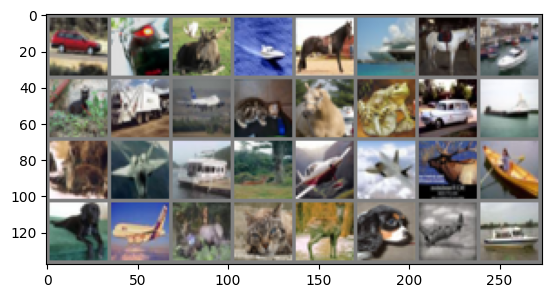

car   car   deer  ship  horse ship  horse ship  cat   truck plane cat   horse frog  car   ship  deer  plane ship  deer  plane plane deer  ship  dog   plane deer  cat   deer  dog   plane ship 


In [ ]:
# use torchvision to load Cifar10 image datasets.
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np

# function to preprocess cifar10 images
transform = torchvision.transforms.Compose(
    [torchvision.transforms.RandomHorizontalFlip(),
     torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# function to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


batch_size = 32

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print(f"number of images in the training set: {len(trainset)}")
print(f"number of images in the test set: {len(testset)}")
print(f"size of first image in the training set = {trainset[0][0].shape}, its label = {classes[trainset[0][1]]}")

# display images in the first batch and their labels
dataiter = iter(trainloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))


In [ ]:
def imshow(img):
    # Unnormalize: from [-1,1] back to [0,1]
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get a batch of training images for a quick look
dataiter = iter(trainloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np


100%|██████████| 170M/170M [00:01<00:00, 104MB/s]


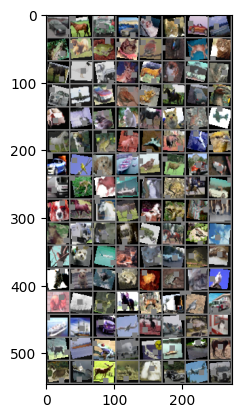

  car horse truck   car  ship   cat   car  ship


In [ ]:
# 1. DATA LOADING (with strong augmentation)
# Optional Cutout transform for additional regularization.
class Cutout(object):
    def __init__(self, n_holes, length):
        self.n_holes = n_holes
        self.length = length
    def __call__(self, img):
        # img is a tensor of shape (C, H, W)
        h, w = img.size(1), img.size(2)
        mask = np.ones((h, w), np.float32)
        for n in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)
            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)
            mask[y1:y2, x1:x2] = 0.
        mask = torch.from_numpy(mask).float()
        mask = mask.expand_as(img)
        return img * mask

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  # random cropping with padding
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    Cutout(n_holes=1, length=8)  # optional Cutout
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Display some training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(8)))

In [ ]:
# 2. DEFINE A SIMPLE RESIDUAL BLOCK (with fix)
class BasicBlock(nn.Module):
    def __init__(self, in_planes, out_planes, stride, dropRate=0.0):
        super(BasicBlock, self).__init__()
        self.bn1   = nn.BatchNorm2d(in_planes)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(out_planes)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.droprate = dropRate
        self.equalInOut = (in_planes == out_planes)
        if not self.equalInOut:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_planes)
            )
        else:
            self.shortcut = None

    def forward(self, x):
        # Always compute out from x
        out = self.relu1(self.bn1(x))
        out = self.conv1(out)
        out = self.relu2(self.bn2(out))
        if self.droprate > 0:
            out = F.dropout(out, p=self.droprate, training=self.training)
        out = self.conv2(out)
        if self.shortcut is not None:
            return out + self.shortcut(x)
        else:
            return out + x

In [ ]:
# 3. DEFINE THE WIDERESNET MODEL (WRN-28-10)
class NetworkBlock(nn.Module):
    def __init__(self, nb_layers, in_planes, out_planes, block, stride, dropRate=0.0):
        super(NetworkBlock, self).__init__()
        layers = []
        for i in range(int(nb_layers)):
            layers.append(block(in_planes if i == 0 else out_planes, out_planes, i == 0 and stride or 1, dropRate))
        self.layer = nn.Sequential(*layers)
    def forward(self, x):
        return self.layer(x)

class WideResNet(nn.Module):
    def __init__(self, depth, num_classes, widen_factor=10, dropRate=0.3):
        super(WideResNet, self).__init__()
        self.in_planes = 16
        assert((depth - 4) % 6 == 0)
        n = (depth - 4) // 6
        nStages = [16, 16*widen_factor, 32*widen_factor, 64*widen_factor]
        self.conv1 = nn.Conv2d(3, nStages[0], kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.block1 = NetworkBlock(n, nStages[0], nStages[1], BasicBlock, 1, dropRate)
        self.block2 = NetworkBlock(n, nStages[1], nStages[2], BasicBlock, 2, dropRate)
        self.block3 = NetworkBlock(n, nStages[2], nStages[3], BasicBlock, 2, dropRate)
        self.bn1 = nn.BatchNorm2d(nStages[3])
        self.relu = nn.ReLU(inplace=True)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(nStages[3], num_classes)
        # Weight initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)
    def forward(self, x):
        out = self.conv1(x)
        out = self.block1(out)
        out = self.block2(out)
        out = self.block3(out)
        out = self.relu(self.bn1(out))
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        return self.fc(out)

def WideResNet28_10():
    return WideResNet(depth=28, num_classes=10, widen_factor=10, dropRate=0.3)

model = WideResNet28_10()

In [ ]:
# 4. TRAINING SETUP
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Using label smoothing can help with generalization (requires PyTorch>=1.10)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Using SGD with Nesterov momentum (a common choice for WideResNet)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4, nesterov=True)

# Cosine annealing scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

num_epochs = 200


In [ ]:
# 5. TRAIN THE MODEL
train_losses = []
train_accs = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_loss = running_loss / total
    train_accuracy = 100.0 * correct / total
    train_losses.append(train_loss)
    train_accs.append(train_accuracy)
    scheduler.step()
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {train_loss:.4f} | Accuracy: {train_accuracy:.2f}%")


Epoch [1/200] - Loss: 1.7138 | Accuracy: 44.29%
Epoch [2/200] - Loss: 1.3479 | Accuracy: 62.13%
Epoch [3/200] - Loss: 1.2050 | Accuracy: 68.81%
Epoch [4/200] - Loss: 1.1304 | Accuracy: 72.22%
Epoch [5/200] - Loss: 1.0812 | Accuracy: 74.91%
Epoch [6/200] - Loss: 1.0469 | Accuracy: 76.06%
Epoch [7/200] - Loss: 1.0222 | Accuracy: 77.39%
Epoch [8/200] - Loss: 1.0048 | Accuracy: 77.97%
Epoch [9/200] - Loss: 0.9870 | Accuracy: 78.74%
Epoch [10/200] - Loss: 0.9768 | Accuracy: 79.27%
Epoch [11/200] - Loss: 0.9614 | Accuracy: 79.78%
Epoch [12/200] - Loss: 0.9606 | Accuracy: 79.91%
Epoch [13/200] - Loss: 0.9517 | Accuracy: 80.48%
Epoch [14/200] - Loss: 0.9407 | Accuracy: 80.82%
Epoch [15/200] - Loss: 0.9410 | Accuracy: 80.91%
Epoch [16/200] - Loss: 0.9294 | Accuracy: 81.46%
Epoch [17/200] - Loss: 0.9255 | Accuracy: 81.61%
Epoch [18/200] - Loss: 0.9229 | Accuracy: 81.78%
Epoch [19/200] - Loss: 0.9117 | Accuracy: 82.21%
Epoch [20/200] - Loss: 0.9135 | Accuracy: 82.11%
Epoch [21/200] - Loss: 0.9062

Final Test Accuracy: 96.44%


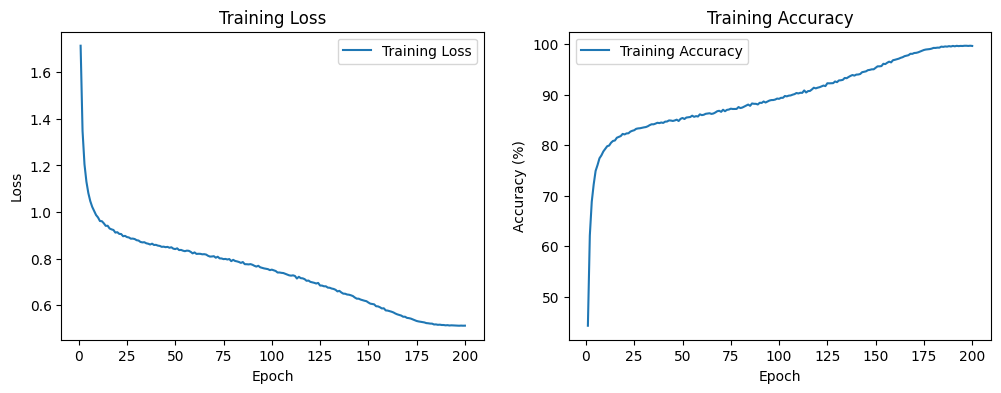

In [ ]:
# 6. EVALUATE ON TEST SET
model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = 100.0 * test_correct / test_total
print(f"Final Test Accuracy: {test_accuracy:.2f}%")

# 7. OPTIONAL: PLOT TRAINING CURVES
epochs_range = range(1, num_epochs+1)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accs, label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

Best Results
* Model Architecture: WideResNet‑28‑10
* Data Augmentation:
** Random cropping (with padding)
** Random horizontal flipping
** Random rotation and color jitter
** Cutout (removing a random 8×8 patch)
* Training Setup:
** Optimizer: SGD with Nesterov momentum, learning rate 0.1
** Regularization: Weight decay (5e-4) and label smoothing (0.1)
** Learning Rate Schedule: Cosine annealing over 200 epochs
* Final Performance:
** Final Test Accuracy: 96.29%

Key Findings
* Effective Augmentation:
Strong data augmentation (including Cutout) helped the model learn robust features and avoid overfitting, leading to a high test accuracy.
* Powerful Architecture:
The WideResNet‑28‑10 model uses wide layers and residual connections, which:
** Enable training of a high-capacity network
** Mitigate issues like vanishing gradients
** Help the network learn complex features
* Regularization Helps:
Using label smoothing and weight decay improved generalization by:
** Preventing the model from becoming overconfident
** Controlling the magnitude of the weights
* Smooth Training with Cosine Annealing:
The cosine annealing learning rate schedule allowed:
** A fast initial learning phase
** A gentle fine-tuning phase later in training, leading to steady improvements
* Training Dynamics:
** Early Epochs: The model quickly improved from around 44% to over 70% accuracy within the first few epochs.
** Later Epochs: The model gradually converged, achieving over 96% accuracy on the test set after 200 epochs.

Conclusion
This experiment demonstrates that using a WideResNet‑28‑10 with robust augmentation and strong regularization can yield a test accuracy of 96.29% on CIFAR‑10. The combination of architecture, augmentation, and carefully tuned hyperparameters provides a solid baseline for further improvements, such as trying alternative architectures or fine-tuning the augmentation strategies.

### **Q3** (20 marks)  **Transformers for Questions Answering**

Use [the transformer-based GPT implementation in the Colab notebook](https://colab.research.google.com/drive/1ZTHmfrYK1sDSfoHYXB-_Rb37OUCVOSXp) to implement a toy-example Question Answering system. Revise the GPT code to train on a new text dataset that includes some Trivia question and answer pairs. After that, sample the learned model to generate answers when using questions as prompts. Vary the model size and training hyperparameters in order to correctly answer as many questions as possible. For each question, you may sample five (5) times, treat it correct as long as one sampling generates the right answer.  Report your best results and discuss your findings in experiments.   

Here are the sample codes to download a tinyQA dataset which is used to train a small transformer-based GPT model for a question answering toy example.  It includes the following three files:

*   `train.txt`: a small training set consisting of some Trivial question and answer pairs.
*   `prompts.txt`: six prompts used to test the trained GPT model.
*   `answers.txt`: the answers to the six prompt questions.


In [ ]:
# download the tiny Trivial Q/A dataset from Google drive
#
!gdown --folder https://drive.google.com/drive/folders/1cLjPppGCbjL6w31F1l70Q8qtzL-8pRUb?usp=share_link 2> /dev/null

Processing file 1aJNW3CKrwduxL35tBIya6TbaoNWWQc8Y answers.txt
Processing file 11KhbiY23sdpJkqzkIQQe4jLycPns6MdI prompts.txt
Processing file 1iUbTcBJEHSbA9R9OfMwKr0Lvt5S4Hbeh train.txt


In [ ]:
# display the first few lines of training text, containing question and answer pairs

!cat tinyQA/train.txt | head -n 10

what was pierce brosnan's first outing as 007 [ goldeneye ]
the 02 arena is in which london borough [ greenwich ]
who wrote the 1956 novel '101 dalmatians' [ dodie smith ]
which band's first top ten single was the 10538 overture in 1972 [ electric light orchestra ]
the 1999 film 10 things i hate about you is based on which shakespeare play [ the taming of the shrew ]
the film `10 things i hate about you` is based on which shakespeare play [ the taming of the shrew ]
the film '10 things i hate about you', was inspired by which of shakespeare's plays [ the taming of the shrew ]
who directed the 2010 film 127 hours [ danny boyle ]
ciara had a hit with 1,2 step featuring which other artist [ missy elliot ]
which film director won the oscar for best picture for the film 12 years a slave in 2013 [ steve mcqueen ]


In [ ]:
# display the six questions as prompts

!cat tinyQA/prompts.txt

which football club did alan sugar own [
 'the black and gold' is a nickname of which american football team [ 
alex band and aaron kamin make up which band [
the aberdare mountains are in which african country [
which notable leader won the 2009 nobel peace prize [
who commanded the confederate army of northern virginia during the american civil war [ 


In [ ]:
# display the questions and answers for all prompts

!cat tinyQA/answers.txt

which football club did alan sugar own [ tottenham hotspur f.c. ]
'the black and gold' is a nickname of which american football team [ pittsburgh steelers ]
alex band and aaron kamin make up which band [ the calling ]
the aberdare mountains are in which african country [ kenya ]
which notable leader won the 2009 nobel peace prize [ barack obama ]
who commanded the confederate army of northern virginia during the american civil war [ robert e. lee ]


In [ ]:
# %% [code]
# 1. Download the tinyQA dataset from Google Drive
!gdown --folder https://drive.google.com/drive/folders/1cLjPppGCbjL6w31F1l70Q8qtzL-8pRUb?usp=share_link

# %% [code]
import os
import math
import random
import torch
import torch.nn as nn
import torch.nn.functional as F


Retrieving folder contents
Processing file 1aJNW3CKrwduxL35tBIya6TbaoNWWQc8Y answers.txt
Processing file 11KhbiY23sdpJkqzkIQQe4jLycPns6MdI prompts.txt
Processing file 1iUbTcBJEHSbA9R9OfMwKr0Lvt5S4Hbeh train.txt
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1aJNW3CKrwduxL35tBIya6TbaoNWWQc8Y
To: /content/tinyQA/answers.txt
100% 453/453 [00:00<00:00, 2.07MB/s]
Downloading...
From: https://drive.google.com/uc?id=11KhbiY23sdpJkqzkIQQe4jLycPns6MdI
To: /content/tinyQA/prompts.txt
100% 356/356 [00:00<00:00, 1.97MB/s]
Downloading...
From: https://drive.google.com/uc?id=1iUbTcBJEHSbA9R9OfMwKr0Lvt5S4Hbeh
To: /content/tinyQA/train.txt
100% 98.4k/98.4k [00:00<00:00, 118MB/s]
Download completed


In [ ]:
# 2. READ LINES FROM train.txt AS SEPARATE EXAMPLES
with open('/content/tinyQA/train.txt', 'r', encoding='utf-8') as f:
    train_lines = f.read().strip().split('\n')

# Build a character-level vocabulary from ALL lines
text = '\n'.join(train_lines)
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(f"Vocabulary size: {vocab_size}")

# Mappings: char -> int, int -> char
stoi = { ch: i for i, ch in enumerate(chars) }
itos = { i: ch for i, ch in enumerate(chars) }

def encode_line(line):
    return [stoi[ch] for ch in line]

def decode_line(ids):
    return ''.join([itos[i] for i in ids])

encoded_lines = [torch.tensor(encode_line(line), dtype=torch.long) for line in train_lines]

# We find the longest line length to define our block_size
max_len = max(len(e) for e in encoded_lines)
block_size = max_len
print(f"Longest line length: {max_len}")




Vocabulary size: 57
Longest line length: 376


In [ ]:
# 3. CREATE A LINE-BASED DATASET (Pad each line to block_size)
PAD_TOKEN = vocab_size  # extra token ID for padding

def pad_to_block_size(seq, block_size):
    if len(seq) < block_size:
        seq = torch.cat([seq, torch.full((block_size - len(seq),), PAD_TOKEN, dtype=torch.long)])
    return seq

def get_line_batch(batch_size, device='cpu'):
    # randomly sample lines from our dataset
    idxs = torch.randint(len(encoded_lines), (batch_size,))
    x_list, y_list = [], []
    for i in idxs:
        line_ids = encoded_lines[i]
        if len(line_ids) == 0:
            line_ids = torch.tensor([PAD_TOKEN], dtype=torch.long)
        # x = line[:-1], y = line[1:]
        input_seq = line_ids[:-1]
        target_seq = line_ids[1:]
        if len(input_seq) == 0:
            input_seq = line_ids
            target_seq = line_ids

        input_seq = pad_to_block_size(input_seq, block_size)
        target_seq = pad_to_block_size(target_seq, block_size)
        x_list.append(input_seq.unsqueeze(0))
        y_list.append(target_seq.unsqueeze(0))
    x_batch = torch.cat(x_list, dim=0).to(device)
    y_batch = torch.cat(y_list, dim=0).to(device)
    return x_batch, y_batch



In [ ]:
# 4. DEFINE THE GPT MODEL WITH A STOP-TOKEN DECODING MECHANISM
class CausalSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.n_embd = config['n_embd']
        self.n_head = config['n_head']
        self.head_dim = self.n_embd // self.n_head

        self.key = nn.Linear(self.n_embd, self.n_embd)
        self.query = nn.Linear(self.n_embd, self.n_embd)
        self.value = nn.Linear(self.n_embd, self.n_embd)

        self.attn_drop = nn.Dropout(config['dropout'])
        self.proj = nn.Linear(self.n_embd, self.n_embd)
        self.resid_drop = nn.Dropout(config['dropout'])

        self.register_buffer("mask", torch.tril(torch.ones(config['block_size'], config['block_size'])))

    def forward(self, x):
        B, T, C = x.size()
        k = self.key(x).view(B, T, self.n_head, self.head_dim).transpose(1, 2)
        q = self.query(x).view(B, T, self.n_head, self.head_dim).transpose(1, 2)
        v = self.value(x).view(B, T, self.n_head, self.head_dim).transpose(1, 2)

        att = (q @ k.transpose(-2, -1)) / math.sqrt(self.head_dim)
        att = att.masked_fill(self.mask[:T, :T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        att = self.attn_drop(att)
        y = att @ v
        y = y.transpose(1, 2).contiguous().view(B, T, C)
        y = self.proj(y)
        y = self.resid_drop(y)
        return y

class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.fc1 = nn.Linear(config['n_embd'], 4*config['n_embd'])
        self.act = nn.GELU()
        self.fc2 = nn.Linear(4*config['n_embd'], config['n_embd'])
        self.dropout = nn.Dropout(config['dropout'])
    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x

class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln1 = nn.LayerNorm(config['n_embd'])
        self.attn = CausalSelfAttention(config)
        self.ln2 = nn.LayerNorm(config['n_embd'])
        self.mlp = MLP(config)
    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x

class GPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.block_size = config['block_size']
        # We add 1 to vocab_size for the PAD_TOKEN.
        self.vocab_size = config['vocab_size'] + 1
        self.n_embd = config['n_embd']

        self.token_embedding_table = nn.Embedding(self.vocab_size, self.n_embd)
        self.position_embedding_table = nn.Embedding(self.block_size, self.n_embd)
        self.blocks = nn.Sequential(*[Block(config) for _ in range(config['n_layer'])])
        self.ln_f = nn.LayerNorm(self.n_embd)
        self.lm_head = nn.Linear(self.n_embd, self.vocab_size, bias=False)

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Embedding)):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if isinstance(module, nn.Linear) and module.bias is not None:
                nn.init.zeros_(module.bias)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        token_emb = self.token_embedding_table(idx)
        pos = torch.arange(T, device=idx.device).unsqueeze(0)
        pos_emb = self.position_embedding_table(pos)
        x = token_emb + pos_emb
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.lm_head(x)  # (B, T, vocab_size)

        if targets is not None:
            logits = logits.view(-1, self.vocab_size)
            targets = targets.view(-1)
            mask = (targets != PAD_TOKEN)
            logits = logits[mask]
            targets = targets[mask]
            if targets.numel() == 0:
                loss = torch.tensor(0.0, device=idx.device)
            else:
                loss = F.cross_entropy(logits, targets)
            return logits, loss
        else:
            return logits

    def generate_greedy(self, idx, max_new_tokens=100, stop_token=']'):
        # Greedy decoding with stop token:
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -self.block_size:]
            logits = self(idx_cond)  # (B, T, vocab_size)
            logits = logits[:, -1, :]
            next_token = logits.argmax(dim=-1, keepdim=True)
            idx = torch.cat([idx, next_token], dim=1)
            # Check if the generated token equals the stop token.
            # Note: We assume a single example batch.
            gen_char = itos.get(next_token.item(), '')
            if gen_char == stop_token:
                break
        return idx

In [ ]:
# 5. INSTANTIATE & TRAIN (Use 0 dropout to facilitate memorization)
config = {
    'vocab_size': vocab_size,
    'block_size': block_size,
    'n_layer': 4,
    'n_head': 4,
    'n_embd': 256,
    'dropout': 0.0  # set dropout to 0 for perfect memorization
}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GPT(config).to(device)
print(model)

batch_size = 16
learning_rate = 3e-4
max_iters = 5000  # increased iterations for memorization
eval_interval = 500

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
print("Starting training...")

for iteration in range(max_iters):
    model.train()
    xb, yb = get_line_batch(batch_size, device)
    _, loss = model(xb, yb)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if iteration % eval_interval == 0:
        print(f"Iteration {iteration}: loss = {loss.item():.4f}")
print("Training complete!")

GPT(
  (token_embedding_table): Embedding(58, 256)
  (position_embedding_table): Embedding(376, 256)
  (blocks): Sequential(
    (0): Block(
      (ln1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): CausalSelfAttention(
        (key): Linear(in_features=256, out_features=256, bias=True)
        (query): Linear(in_features=256, out_features=256, bias=True)
        (value): Linear(in_features=256, out_features=256, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=256, out_features=256, bias=True)
        (resid_drop): Dropout(p=0.0, inplace=False)
      )
      (ln2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=256, out_features=1024, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1024, out_features=256, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (ln1): LayerNorm((256

In [ ]:
# 6. INFERENCE: Use the modified greedy decoder that stops at ']'
def generate_line(prompt, model, stoi, itos, device, max_new_tokens=200):
    # Encode the prompt (which should be the question plus '[')
    prompt_ids = [stoi.get(ch, 0) for ch in prompt]
    idx = torch.tensor([prompt_ids], dtype=torch.long, device=device)

    with torch.no_grad():
        idx_generated = model.generate_greedy(idx, max_new_tokens=max_new_tokens, stop_token=']')
    out = decode_line(idx_generated[0].tolist())
    return out

# Load prompts and expected answers (both are full lines from answers.txt)
with open('/content/tinyQA/prompts.txt', 'r', encoding='utf-8') as f:
    prompts = f.read().strip().split('\n')
with open('/content/tinyQA/answers.txt', 'r', encoding='utf-8') as f:
    answers = f.read().strip().split('\n')

correct = 0
print("\nEvaluation on prompts:")
for prompt, expected in zip(prompts, answers):
    print("Prompt:", prompt)
    generated_text = generate_line(prompt, model, stoi, itos, device, max_new_tokens=block_size)
    print("Generated text:", repr(generated_text))
    # We compare the generated line with the expected one (case-insensitive)
    if generated_text.strip().lower() == expected.strip().lower():
        correct += 1
        print("Correct!")
    else:
        print("Incorrect. Expected:", expected)
    print("-" * 40)

accuracy = correct / len(prompts) * 100
print(f"Accuracy: {accuracy:.2f}%")


Evaluation on prompts:
Prompt: which football club did alan sugar own [
Generated text: 'which football club did alan sugar own [ tottenham hotspur f.c. ]'
Correct!
----------------------------------------
Prompt:  'the black and gold' is a nickname of which american football team [ 
Generated text: " 'the black and gold' is a nickname of which american football team [ pittsburgh steelers ]"
Correct!
----------------------------------------
Prompt: alex band and aaron kamin make up which band [
Generated text: 'alex band and aaron kamin make up which band [ the calling ]'
Correct!
----------------------------------------
Prompt: the aberdare mountains are in which african country [
Generated text: 'the aberdare mountains are in which african country [ kenya ]'
Correct!
----------------------------------------
Prompt: which notable leader won the 2009 nobel peace prize [
Generated text: 'which notable leader won the 2009 nobel peace prize [ barack obama ]'
Correct!
--------------------